In [8]:
#%%
import pandas as pd
import numpy as np
import dask.dataframe as dd 
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import re
import random
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics, svm
%matplotlib inline

In [2]:
train = pd.read_csv('c:/Users/joe/desktop/train_2016_v2.csv',parse_dates=['transactiondate'])

# load the properties data
prp = pd.read_csv('c:/Users/joe/desktop/properties_2016.csv')

merged = pd.merge(train,prp,on='parcelid',how='left')

C:\Users\Joe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Linear Variable Combinations
merged['property_age'] = 2018 - merged['yearbuilt']
merged['total_rooms'] = merged['calculatedbathnbr'] + merged['bedroomcnt']
merged['garage_yn'] = np.where((merged['garagecarcnt'] > 0) | (merged['garagetotalsqft'] > 0),1,0)
merged['prop_to_land'] = merged['structuretaxvaluedollarcnt']/merged['landtaxvaluedollarcnt']
merged['length_tax_delinq'] = 2018 - merged['taxdelinquencyyear']
merged['coords'] = merged['latitude']/(10^6) + merged['longitude']/(10^6)
zip_count = merged['regionidzip'].value_counts().to_dict()
merged['zip_counts'] = merged['regionidzip'].map(zip_count)
city_count = merged['regionidcity'].value_counts().to_dict()
merged['city_counts'] = merged['regionidcity'].map(city_count)
county_count = merged['regionidcounty'].value_counts().to_dict()
merged['county_counts'] = merged['regionidcounty'].map(county_count)
merged['ac_yn'] = (merged['airconditioningtypeid']!=5)*1
merged['heat_yn'] = (merged['heatingorsystemtypeid']!=13)*1
merged['property_type'] = merged.propertylandusetypeid.replace({31 : "Mixed", 46 : "Other", 47 : "Mixed",
      246 : "Mixed", 247 : "Mixed", 248 : "Mixed",
      260 : "Home", 261 : "Home", 262 : "Home",
      263 : "Home", 264 : "Home", 265 : "Home",
      266 : "Home", 267 : "Home", 268 : "Home",
      269 : "Not Built", 270 : "Home", 271 : "Home",
      273 : "Home", 274 : "Other", 275 : "Home",
      276 : "Home", 279 : "Home", 290 : "Not Built",
      291 : "Not Built" }) 
# structuretaxvaluedollarcnt by city
group = merged.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
merged['stvdc_avg_bycity'] = merged['regionidcity'].map(group)
merged['stvdc_avg_dev'] = abs((merged['structuretaxvaluedollarcnt'] - merged['stvdc_avg_bycity']))/merged['stvdc_avg_bycity']

In [5]:
high = np.percentile(np.log(merged['taxvaluedollarcnt'].dropna()),99)
low = np.percentile(np.log(merged['taxvaluedollarcnt'].dropna()),1)
mor = merged[(np.log(merged['taxvaluedollarcnt']) > low) & (np.log(merged['taxvaluedollarcnt']) < high)]

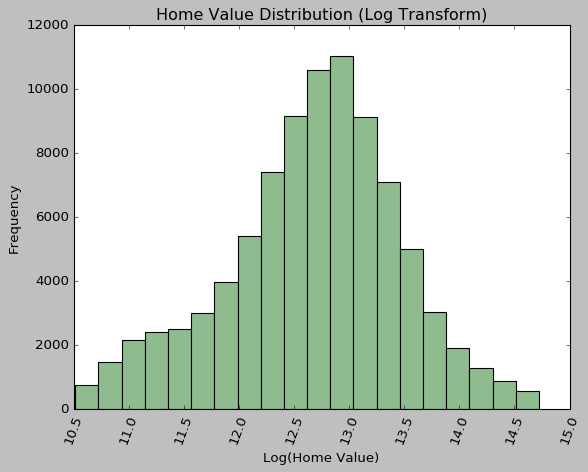

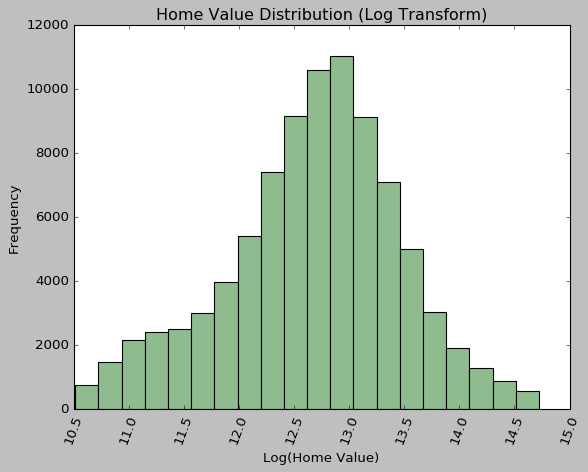

In [7]:
plt.style.use('classic')
fig,ax = plt.subplots()
high = np.percentile(merged['taxvaluedollarcnt'].dropna(),99)
low = np.percentile(merged['taxvaluedollarcnt'].dropna(),1)
mor = merged[(merged['taxvaluedollarcnt'] > low) & (merged['taxvaluedollarcnt'] < high)]
plt.hist(np.log(mor['taxvaluedollarcnt']),bins=20, color='darkseagreen')
plt.title('Home Value Distribution (Log Transform)')
plt.ylabel('Frequency')
plt.xlabel('Log(Home Value)')
plt.xticks(rotation = 70)
plt.show()

In [10]:
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = np.log(mor['taxvaluedollarcnt'])
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[5,10,15], 'n_jobs':[-1], 'oob_score':[False]}
model = RandomForestRegressor()
grid = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3)
grid.fit(xtrain,ytrain)
print(resultsdf[["param_n_estimators","mean_test_score","std_test_score"]])

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


TypeError: float() argument must be a string or a number, not 'Timestamp'

In [ ]:
# Feature Importance
feat_imps = grid.best_estimator_.feature_importances_
fi = pd.DataFrame.from_dict({'feat':xtrain.columns,'imp':feat_imps})
fi.set_index('feat',inplace=True,drop=True)
fi = fi.sort_values('imp',ascending=False)
fi.head(20).plot.bar()

In [13]:
# Random Forest Without Multicollinearity
# Preprocessing
data = mor.select_dtypes(exclude=[object])
data.fillna(-1,inplace=True)
data['target'] = np.log(mor['taxvaluedollarcnt'])
X = data.drop(['parcelid','taxvaluedollarcnt','target','logerror','transactiondate','landtaxvaluedollarcnt','taxamount','structuretaxvaluedollarcnt'],axis=1)
y = data['target']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33,random_state=42)
# Fit Random Forest
parameters = {'n_estimators':[5,10,15], 'n_jobs':[-1], 'oob_score':[False]}
model = RandomForestRegressor()
grid = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3)
grid.fit(xtrain,ytrain)
print("Random Forest MSE:",np.mean(grid.predict(xtest)-ytest)**2)

C:\Users\Joe\Anaconda3\lib\site-packages\pandas\core\frame.py:2852: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
C:\Users\Joe\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Random Forest MSE: 5.633086241784274e-06


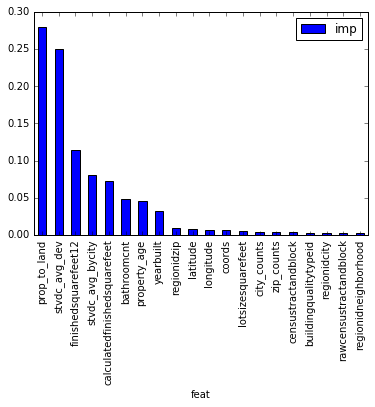

In [14]:
# Feature Importance
feat_imps = grid.best_estimator_.feature_importances_
fi = pd.DataFrame.from_dict({'feat':xtrain.columns,'imp':feat_imps})
fi.set_index('feat',inplace=True,drop=True)
fi = fi.sort_values('imp',ascending=False)
fi.head(20).plot.bar()

In [ ]:
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
#svrreg = LinearSVR(C=1,roandom_state=42,tol=1e-5, epsilon=1)
svrreg = SVR(C=1,tol=1e-5, epsilon=1, kernel='rbf')
svrreg.fit(xtrain, ytrain)
pred = svrreg.predict(xtest)
print(svrreg.score(xtest,ytest))
print("Support Vector Regression MSE:",np.mean((svrreg.predict(xtest)-ytest)**2))

In [ ]:
# Linear Regression
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(xtrain, ytrain)
pred = regr.predict(xtest)
print(regr.score(xtest,ytest))
print("Linear Regression MSE:",np.mean((regr.predict(xtest)-ytest)**2))

In [ ]:
# Lasso
from sklearn import linear_model
clf = linear_model.Lasso(alpha=1e-6,normalize=True,max_iter=10000)
clf.fit(xtrain,ytrain)
lpred = clf.predict(xtest)
print(regr.score(xtest,ytest))
print("Lasso MSE:",np.mean((regr.predict(xtest)-ytest)**2))

In [ ]:
# Elastic Net
#from sklearn import linear_model
clf = linear_model.ElasticNet(alpha=1e-6,normalize=True)
clf.fit(xtrain,ytrain)
lpred = clf.predict(xtest)
print(regr.score(xtest,ytest))
print("Elastic Net MSE:",np.mean((regr.predict(xtest)-ytest)**2))

In [ ]:
# K Nearest Neighbor Regressor
from sklearn.neighbors import KNeighborsRegressor
reg = KNeighborsRegressor(n_neighbors=100)
reg.fit(xtrain,ytrain)
kpred = reg.predict(xtest)
print(reg.score(xtest,ytest))
print("K Nearest Neighbor MSE:",np.mean((reg.predict(xtest)-ytest)**2))

In [ ]:
# Neural Network Model
from sklearn.neural_network import MLPRegressor
# Normalize Data
train_y=(ytrain-ytrain.min())/(ytrain.max()-ytrain.min())
train_x=(xtrain-xtrain.min())/(xtrain.max()-xtrain.min())
test_x=(xtest-xtest.min())/(xtest.max()-xtest.min())
test_y=(ytest-ytest.min())/(ytest.max()-ytest.min())
train_y = train_y.fillna(0)
train_x = train_x.fillna(0)
test_y = test_y.fillna(0)
test_x = test_x.fillna(0)
nnreg = MLPRegressor(hidden_layer_sizes=(100,),activation='logistic',solver='lbfgs',max_iter=10000)
nnreg.fit(train_x,train_y)
nnpred = nnreg.predict(test_x)
print(nnreg.score(test_x,test_y))
print("Neural Network MSE:",np.mean((nnreg.predict(test_x)-test_y)**2))

In [ ]:
# Kmeans around Lat/Lon
from sklearn.cluster import KMeans
data['regionidzip']=merged['regionidzip'].fillna(97000)
data.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
data['longitude'] = merged['longitude']
data['latitude'] = merged['latitude']
id_n = 9
X = merged.loc[:,['latitude','longitude']]
km = KMeans(n_clusters=id_n, random_state=42).fit(X)
id_label = km.labels_
zp = merged.regionidzip

In [ ]:
# Clusters Map
ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^','g*']);
plt.figure(figsize=(12,12))
plt.ylabel('Latitude', fontsize=12)
plt.xlabel('Longitude', fontsize=12)
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    plt.plot(X.longitude[cluster].values,X.latitude[cluster].values,ptsymb[i])
plt.title('K-Means Clustering By Lat/Lon')
plt.show()